In [57]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 100

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from os import listdir
import unicodedata

from paths import *
from scripts.manipulation import remove_acentos
from scripts.manipulation import normalize_cols
from scripts import scrap_data
from scripts import manipulation
from scripts import io
from scripts import vis_graphs

from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

import yaml


Boletim SP

https://www.seade.gov.br/coronavirus/?utm_source=portal&utm_medium=banner&utm_campaign=boletim-completo

## Casos

In [58]:
sp_full = pd.read_csv('https://raw.githubusercontent.com/seade-R/dados-covid-sp/master/data/dados_covid_sp.csv', sep=';')
sp_full['nome_drs'] = np.where(sp_full['nome_munic']=='São Paulo','Município de São Paulo',sp_full['nome_drs'])

cols = ['datahora','nome_munic','casos','obitos','nome_drs']
sp = sp_full[cols][sp_full['nome_drs'].notnull()]

sp = sp.groupby(by=['nome_drs','datahora'], as_index=False).sum().sort_values(by=['nome_drs','datahora'])

estado = sp.groupby(by=['datahora'], as_index=False).sum().sort_values(by=['datahora'])
estado['nome_drs'] = 'Estado de São Paulo'
estado = estado[sp.columns]

sp = pd.concat([sp,estado],axis=0)

In [59]:
sp['casos'] = sp['casos'].astype(int)
sp['obitos'] = sp['obitos'].astype(int)

In [60]:
sp['nome_drs'].unique()

array(['Araraquara', 'Araçatuba', 'Baixada Santista', 'Barretos', 'Bauru',
       'Campinas', 'Franca', 'Grande São Paulo', 'Marília',
       'Município de São Paulo', 'Piracicaba', 'Presidente Prudente',
       'Registro', 'Ribeirão Preto', 'Sorocaba', 'São José do Rio Preto',
       'São João da Boa Vista', 'Taubaté', 'Estado de São Paulo'],
      dtype=object)

In [61]:
dd_final_all = pd.DataFrame()

for drs in sp['nome_drs'].unique():

    tbt = sp[sp['nome_drs']==drs]

    tbt['casos_shift'] = tbt['casos'].shift(7)
    tbt['obitos_shift'] = tbt['obitos'].shift(7)

    tbt['casos_7'] = tbt['casos'] - tbt['casos_shift']
    tbt['obitos_7'] = tbt['obitos'] - tbt['obitos_shift']

    tbt['casos_7_shift'] = tbt['casos_7'].shift(7)
    tbt['obitos_7_shift'] = tbt['obitos_7'].shift(7)

    tbt['casos_var'] = tbt['casos_7']/tbt['casos_7_shift']
    tbt['obitos_var'] = tbt['obitos_7']/tbt['obitos_7_shift']

    dd = tbt[['datahora','nome_drs','casos_var','obitos_var']]

    dd_final_all = pd.concat([dd_final_all,dd], axis=0)

    
mask = dd_final_all['datahora'] == max(dd_final_all['datahora'])
dd_final = dd_final_all[mask]

## Internacoes

In [62]:
sp_cv = pd.read_csv('https://github.com/seade-R/dados-covid-sp/raw/master/data/plano_sp_leitos_internacoes.csv', sep=';')
sp_cv['internacoes_var'] = sp_cv['internacoes_7d']/sp_cv['internacoes_7d_l']
cols = ['datahora','nome_drs','leitos_pc','internacoes_var']
uti_all = sp_cv[cols]

last_data =  max(uti_all['datahora'])


mask = uti_all['datahora'] == last_data
uti_all['nome_drs'] = uti_all['nome_drs'].apply(lambda x: x[7:] if x[:3]=='DRS' else x).str.strip()


df_final = uti_all[mask][cols]


In [63]:
df_final

,datahora,nome_drs,leitos_pc,internacoes_var
1334,2020-07-16,Município de São Paulo,"31,07",1.023711
1335,2020-07-16,Grande SP Leste,"15,53",1.046176
1336,2020-07-16,Grande SP Norte,"19,93",1.026846
1337,2020-07-16,Grande SP Oeste,"18,90",1.305040
1338,2020-07-16,Grande SP Sudeste,"31,37",1.040976
1339,2020-07-16,Grande SP Sudoeste,"10,23",1.131222
1340,2020-07-16,Araçatuba,"13,07",0.812500
1341,2020-07-16,Araraquara,"9,68",0.991935
1342,2020-07-16,Baixada Santista,"26,26",0.934354
1343,2020-07-16,Barretos,"17,41",0.905512


In [64]:
dd_final

,datahora,nome_drs,casos_var,obitos_var
142,2020-07-16,Araraquara,1.202226,1.888889
285,2020-07-16,Araçatuba,1.131929,0.958333
428,2020-07-16,Baixada Santista,0.648315,1.182927
571,2020-07-16,Barretos,1.041667,1.833333
714,2020-07-16,Bauru,1.194963,1.700000
857,2020-07-16,Campinas,1.002513,1.028436
1000,2020-07-16,Franca,1.219697,1.545455
1143,2020-07-16,Grande São Paulo,0.947310,1.006667
1286,2020-07-16,Marília,1.069257,0.357143
1429,2020-07-16,Município de São Paulo,1.318843,1.045455


## Ocupacao UTI

In [65]:
uti = pd.read_csv('../data/sp_gov/uti_ocupacao.csv', sep=';')
uti_final = uti[uti['datahora']==max(uti['datahora'])]


# uti_final['datahora'] = last_data

## Add Fases

In [66]:

df = pd.merge(dd_final,df_final,on=['datahora','nome_drs'],how='outer').merge(uti_final,on=['datahora','nome_drs'],how='outer')
mask = df['nome_drs'].str.startswith('Grande')
df = df[np.logical_not(mask)]
df['leitos_pc'] = df['leitos_pc'].str.replace(',','.')

df = df.round(2)

def uti_fase(x):
    if x>=80:
        fase=1
    elif (x <80) & (x>=70):
        fase=2
    elif (x <70) & (x>=60):
        fase=3
    else:
        fase = 4
    return fase

def leitos_fase(x):
    if x<=3:
        fase=1
    elif (x >3) & (x<=5):
        fase=2
    else:
        fase = 4
    return fase


O = df['uti_var'].apply(lambda x: uti_fase(x))

L = df['leitos_pc'].str.replace(',','.').astype(float).apply(lambda x: leitos_fase(x))


c1 = (O*4 + L)/5

df['Capacidade Hospitalar'] = c1.astype(int)

def casos_fase(x):
    if x>=2:
        fase=1
    elif (x <2) & (x>=1):
        fase=3
    else:
        fase = 4
    return fase

def internacoes_fase(x):
    if x>=1.5:
        fase=1
    elif (x <1.5) & (x>=1):
        fase=2
    elif (x <1) & (x>=0.5):
        fase=3
    else:
        fase = 4
    return fase

def obitos_fase(x):
    if x>=2:
        fase=1
    elif (x <2) & (x>=1):
        fase=2
    elif (x <1) & (x>=0.5):
        fase=3
    else:
        fase = 4
    return fase
NC = df['casos_var'].apply(lambda x: casos_fase(x))

NI = df['internacoes_var'].apply(lambda x: internacoes_fase(x))

NO = df['obitos_var'].apply(lambda x: obitos_fase(x))

c2 = (NC + 3*NI + NO)/5

df['Evolução da Pandemia'] = c2

df['casos_var'] = df['casos_var'].round(2).astype(str)
df['obitos_var'] = df['obitos_var'].round(2).astype(str)
df['internacoes_var'] = df['internacoes_var'].round(2).astype(str)
df['uti_var'] = df['uti_var'].round(2).astype(str)

df['Classif. Final'] = df[['Capacidade Hospitalar','Evolução da Pandemia']].min(axis=1)

df['Classif. Final'] = df['Classif. Final'].astype(int).astype(str)
df['Evolução da Pandemia'] = df['Evolução da Pandemia'].astype(int).astype(str)
df['Capacidade Hospitalar'] = df['Capacidade Hospitalar'].astype(int).astype(str)

## Padronize 

In [67]:

cols = ['datahora','nome_drs','Capacidade Hospitalar','uti_var','leitos_pc','Evolução da Pandemia','casos_var','internacoes_var','obitos_var','Classif. Final']


rename_drs = {
    'Araraquara':'DRS 03 - Araraquara',
    'Araçatuba':'DRS 02 - Araçatuba',
    'Baixada Santista':'DRS 04 - Baixada Santista',
    'Barretos':'DRS 05 - Barretos',
    'Bauru':'DRS 06 - Bauru',
    'Campinas':'DRS 07 - Campinas',
    'Estado de São Paulo':'Estado de São Paulo',
    'Franca':'DRS 08 - Franca',
    'Marília':'DRS 09 - Marília',
    'Município de São Paulo':'DRS 01 - Município de São Paulo',
    'Piracicaba':'DRS 10 - Piracicaba',
    'Presidente Prudente':'DRS 11 - Presidente Prudente',
    'Registro':'DRS 12 - Registro',
    'Ribeirão Preto':'DRS 13 - Ribeirão Preto',
    'Sorocaba':'DRS 16 - Sorocaba',
    'São José do Rio Preto':'DRS 15 - São José do Rio Preto',
    'São João da Boa Vista':'DRS 14 - São João da Boa Vista',
    'Taubaté':'DRS 17 - Taubaté'
}

df['nome_drs'] = df['nome_drs'].map(rename_drs)

cols_rename ={
    'datahora':'Data',
    'nome_drs':'DRS',
    'casos_var':'Variação de casos',
    'obitos_var':'Variação de óbitos',
    'leitos_pc':'Leitos COVID/100 mil hab',
    'internacoes_var':'Variação internações',
    'uti_var':'Ocupação leitos UTI COVID',
}




df = df[cols].rename(columns=cols_rename).sort_values(by='DRS')

df = pd.concat([df.tail(1),df.head(17)],axis=0).reset_index(drop=True)


## Colored Table

In [68]:
def cases_color(val):
    if val == '1':
        color = 'red'
    elif val=='2':
        color = 'orange'
    elif val=='3':
        color = 'yellow'
    else:
        color = 'green'
    return 'background-color: %s' % color

df.style.applymap(cases_color, subset=pd.IndexSlice[:, ['Capacidade Hospitalar','Evolução da Pandemia','Classif. Final']] )

,Data,DRS,Capacidade Hospitalar,Ocupação leitos UTI COVID,Leitos COVID/100 mil hab,Evolução da Pandemia,Variação de casos,Variação internações,Variação de óbitos,Classif. Final
0,2020-07-16,Estado de São Paulo,3,65.0,20.49,2,1.1,1.07,1.09,2
1,2020-07-16,DRS 01 - Município de São Paulo,3,67.7,31.07,2,1.32,1.02,1.05,2
2,2020-07-16,DRS 02 - Araçatuba,3,63.9,13.07,3,1.13,0.81,0.96,3
3,2020-07-16,DRS 03 - Araraquara,4,35.4,9.68,2,1.2,0.99,1.89,2
4,2020-07-16,DRS 04 - Baixada Santista,4,48.0,26.26,3,0.65,0.93,1.18,3
5,2020-07-16,DRS 05 - Barretos,3,66.8,17.41,2,1.04,0.91,1.83,2
6,2020-07-16,DRS 06 - Bauru,3,64.5,10.94,2,1.19,1.26,1.7,2
7,2020-07-16,DRS 07 - Campinas,2,79.6,19.11,2,1.0,1.09,1.03,2
8,2020-07-16,DRS 08 - Franca,1,86.9,7.84,2,1.22,1.2,1.55,1
9,2020-07-16,DRS 09 - Marília,4,45.1,11.24,2,1.07,1.34,0.36,2


In [77]:
mask = (dd_final_all['casos_var'].notnull()) & (dd_final_all['obitos_var'].notnull()) & (dd_final_all['obitos_var']!= np.inf)
aux_df = dd_final_all[mask]

final = pd.merge(aux_df,uti_all,on=['datahora','nome_drs'],how='outer')
mask = final['nome_drs'].str.startswith('Grande')
final = final[np.logical_not(mask)]
final['leitos_pc'] = final['leitos_pc'].str.replace(',','.')

final = final[(final['leitos_pc'].notnull()) & (final['casos_var'].notnull())]

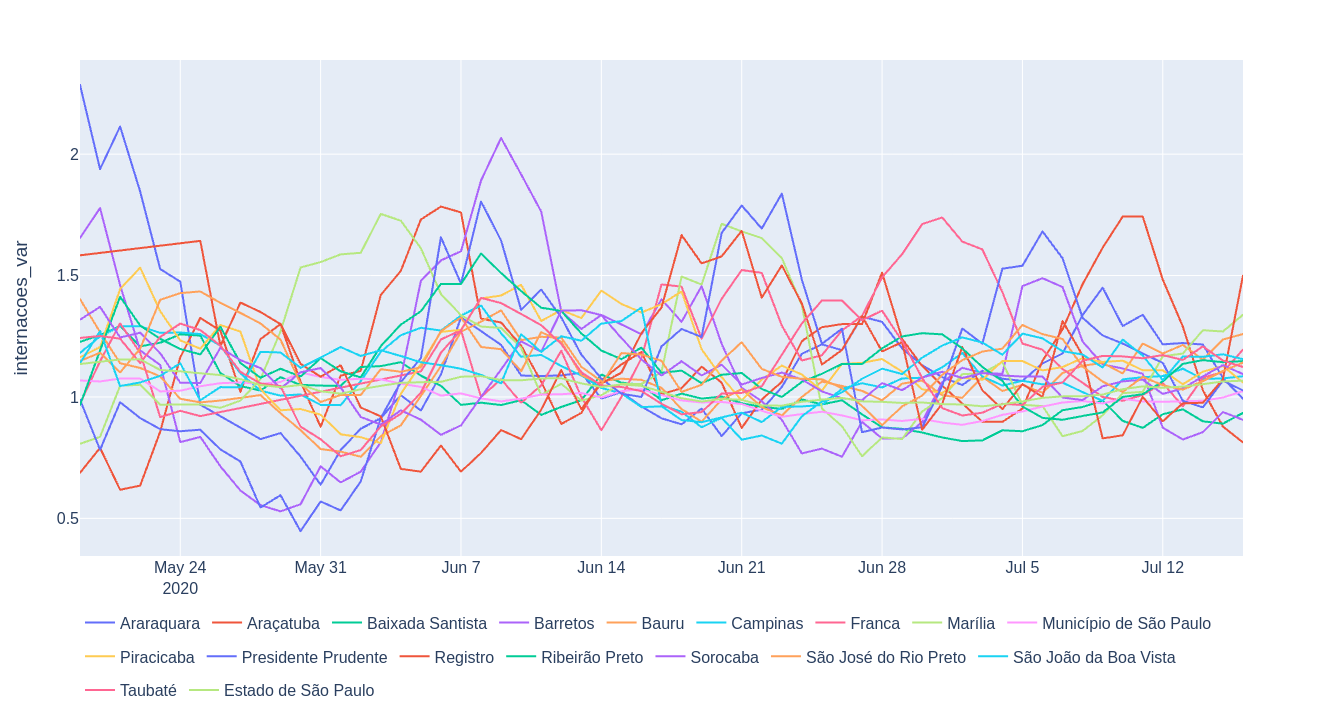

In [84]:
fig = px.line(final, x='datahora',y='internacoes_var', color='nome_drs', height=720)
fig.update_layout(hovermode= 'x unified',legend = go.layout.Legend(orientation='h'), xaxis_title='', font = dict(size=16))


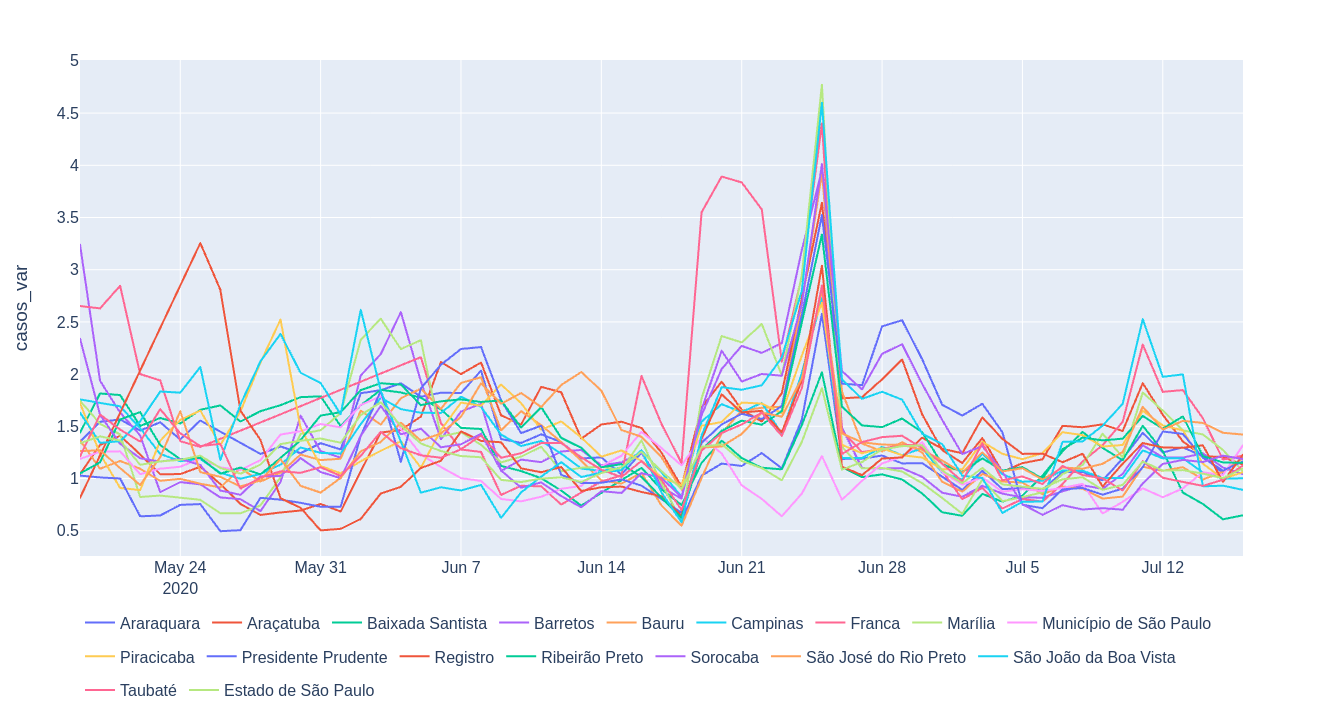

In [85]:
fig = px.line(final, x='datahora',y='casos_var', color='nome_drs', height=720)
fig.update_layout(hovermode= 'x unified',legend = go.layout.Legend(orientation='h'), xaxis_title='', font = dict(size=16))


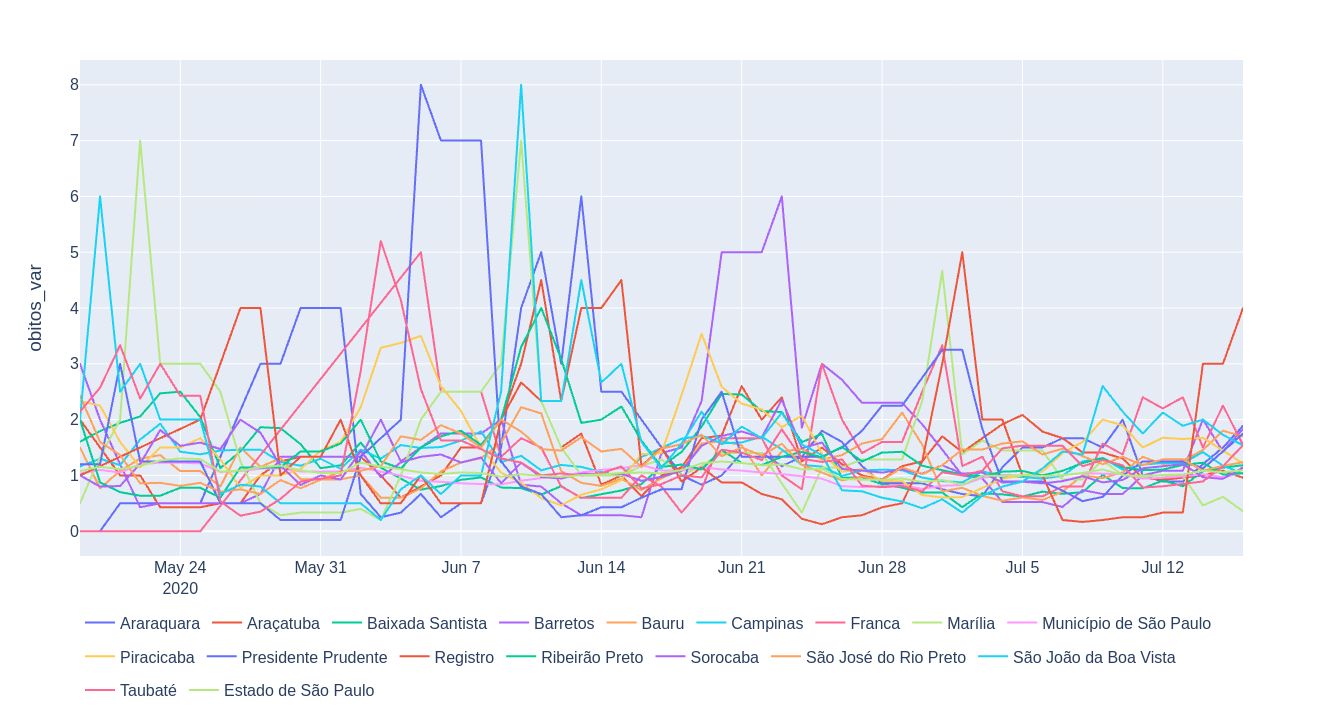

In [87]:
fig = px.line(final, x='datahora',y='obitos_var', color='nome_drs', height=720)
fig.update_layout(hovermode= 'x unified',legend = go.layout.Legend(orientation='h'), xaxis_title='', font = dict(size=16))


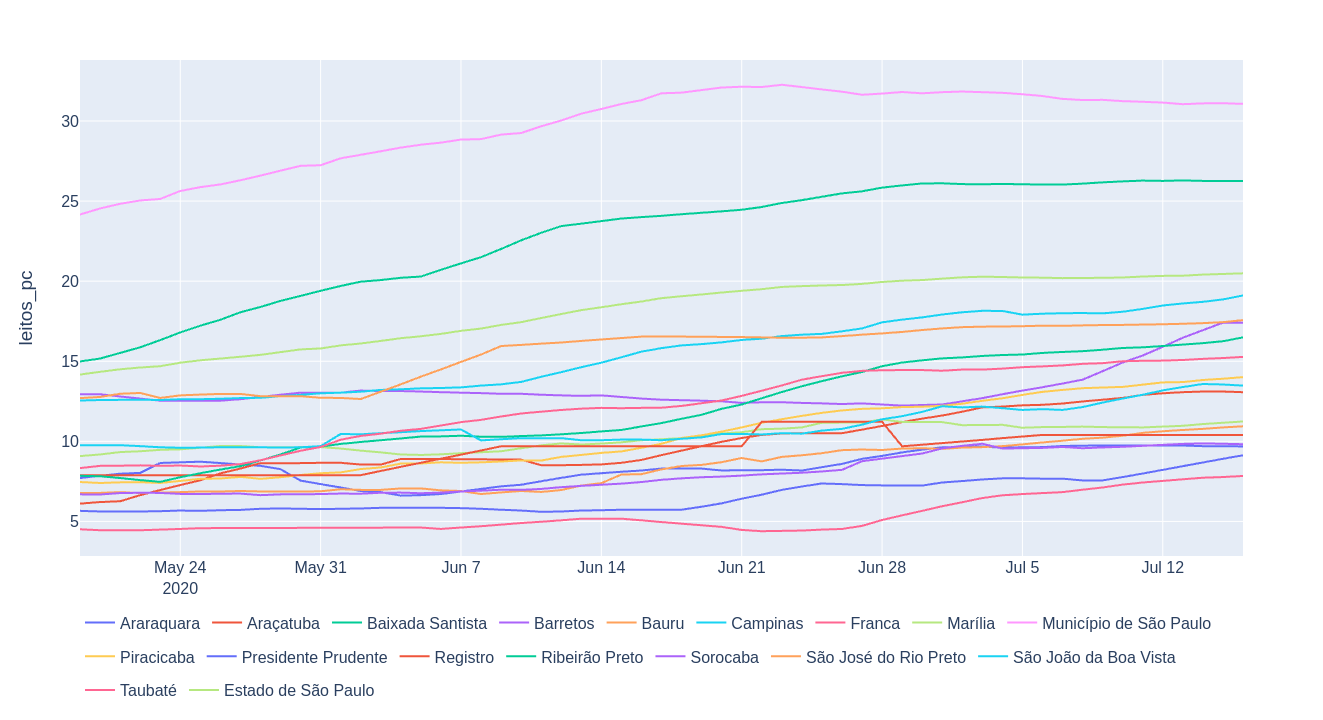

In [88]:
fig = px.line(final, x='datahora',y='leitos_pc', color='nome_drs', height=720)
fig.update_layout(hovermode= 'x unified',legend = go.layout.Legend(orientation='h'), xaxis_title='', font = dict(size=16))


In [86]:
final.head()

,datahora,nome_drs,casos_var,obitos_var,leitos_pc,internacoes_var
28,2020-05-19,Araraquara,1.351351,0.0,7.71,2.285714
29,2020-05-20,Araraquara,1.542857,0.0,7.85,1.938272
30,2020-05-21,Araraquara,1.565789,0.5,7.98,2.113924
31,2020-05-22,Araraquara,1.459770,0.5,8.03,1.846154
32,2020-05-23,Araraquara,1.538462,0.5,8.65,1.526786
